# Social Media Analytics
## Webscraping Project¶
### Introduction to Text Mining
### Frequency Analysis
Felix Funes 20220306 | Paula Catalan 20221048 | Efstathia Styliagkatzi 20220078 | Alisson Tapia 20221156 | S M Abrar Hossain Asif 20220223

Some of the importan reason of doing Frequency in our data are:

Signal Processing: Helps in understanding the spectral content of a signal. By analyzing the frequency components present in a signal, you can extract valuable information, filter out noise, identify patterns, and perform various operations such as noise reduction, compression, equalization, and modulation/demodulation.

Image Processing: In image processing, frequency analysis is employed in techniques such as Fourier analysis or the discrete cosine transform (DCT) to analyze the spatial frequency content of an image. This analysis helps in tasks like image compression (e.g., JPEG compression), image filtering, feature extraction, and image recognition.

Data Visualization: Can be used to reveal patterns and structures in data. By visualizing the frequency spectrum of a dataset, you can identify dominant frequencies, periodic behavior, and anomalies. This information is valuable for understanding the underlying characteristics of the data and making informed decisions.

Machine Learning: Can be employed as a preprocessing step in machine learning tasks. For example, in natural language processing, you can perform frequency analysis on text data to identify the most frequent words or n-grams, which can then be used as features in a machine learning model.

In [25]:
# Import packages
import csv
import pandas as pd
import numpy as np
import nltk 
import re
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

In [26]:
# Load dataset
dtypes = {'device':'category','user':'category','rating':'integer','ownership_lenght':'category'}
ds = pd.read_excel("ExtractedReviewsDataCollection_bestbuy.xlsx", sheet_name="Sheet1", index_col = 0)

## Functions

In [27]:
# Text preprocessing
def textPreProcess(rawText, removeHTML=True, charsToRemove = r'\?|\.|\!|\;|\.|\"|\,|\(|\)|\&|\:|\-', removeNumbers=True, removeLineBreaks=False, specialCharsToRemove = r'[^\x00-\xfd]', convertToLower=True, removeConsecutiveSpaces=True):
    if type(rawText) != str:
        return rawText
    procText = rawText
        
    # Remove HTML
    if removeHTML:
        procText = BeautifulSoup(procText,'html.parser').get_text()

    # Remove punctuation and other special characters
    if len(charsToRemove)>0:
        procText = re.sub(charsToRemove,' ',procText)

    # Remove numbers
    if removeNumbers:
        procText = re.sub(r'\d+',' ',procText)

    # Remove line breaks
    if removeLineBreaks:
        procText = procText.replace('\n',' ').replace('\r', '')

    # Remove special characters
    if len(specialCharsToRemove)>0:
        procText = re.sub(specialCharsToRemove,' ',procText)

    # Normalize to lower case
    if convertToLower:
        procText = procText.lower() 

    # Replace multiple consecutive spaces with just one space
    if removeConsecutiveSpaces:
        procText = re.sub(' +', ' ', procText)

    return procText

In [28]:
# Tokenize words
def tokenize_words(words):
    if (type(words) != str) or (word_tokenize(words) == ''):
        return np.nan
    else:
        return word_tokenize(words)

In [29]:
# Stemm texts
def stemming(words):
    stemmed_word = [snowball.stem(x) for x in (words[:])]
    return stemmed_word

In [30]:
# Function to count the frequency of n-grams (Adapted from https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34)
# Uses CountVectorizer from sklearn instead of FreqDist from NLTK
def get_top_n_words(corpus, n=None, nGrams=1): 
    vec = CountVectorizer(max_df=0.8, stop_words=stop_words,ngram_range=(nGrams,nGrams), max_features=10000).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

## Analysis

In [31]:
# Create a dataframe with only the description
processedReviews =  pd.DataFrame(data=ds.text.apply(textPreProcess).values, index=ds.index, columns=['PreProcessedText']) 

C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [8]:
# Tokenize text
processedReviews['Words'] =  processedReviews['PreProcessedText'].apply(tokenize_words)

In [9]:
# Compute terms frequency distribution
from nltk.probability import FreqDist
fdist = FreqDist()
for review in processedReviews.Words:
  for term in review:
    fdist[term]+=1

In [10]:
# Transform results to a sorted dataframe
df_fdist = pd.DataFrame.from_dict(fdist, orient='index')
df_fdist.columns = ['Frequency']
df_fdist.index.name = 'Term'
df_fdist = df_fdist.sort_values(by='Frequency', ascending=False)

In [11]:
# Top 15
df_fdist.head(15)

,Frequency
Term,
the,395
and,287
i,279
phone,242
to,236
a,213
it,207
is,196
my,181


In [12]:
# Low 15
df_fdist.tail(15)

,Frequency
Term,
discounts,1
payments,1
upfront,1
giving,1
prefer,1
systems,1
seamless,1
kohler,1
efficient,1


In [13]:
# Remove stopwords and re-explore results
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
df_fdist = df_fdist[~df_fdist.index.isin(stop_words)]
df_fdist.head(15)

,Frequency
Term,
phone,242
iphone,167
great,134
love,81
new,71
camera,62
good,59
battery,53
best,49


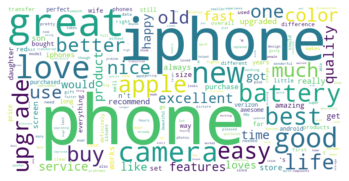

In [14]:
# Create a Word Cloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white', contour_color='white')
wordcloud.generate_from_frequencies(frequencies=df_fdist.Frequency)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


The word cloud shows some words have the same origin, such as "great" and "greatest". Let's create a stemmed version of the word cloud

In [15]:
# Create a stemmed version of the words to normalize the Lexicon
# Import package
from nltk.stem import SnowballStemmer

In [16]:
# Check languages supported
print(" ".join(SnowballStemmer.languages))

arabic danish dutch english finnish french german hungarian italian norwegian porter portuguese romanian russian spanish swedish


In [17]:
# Do stemming
snowball = SnowballStemmer("english")
# Create a new column for stemm words
processedReviews['StemmedWords'] = processedReviews['Words'].apply(stemming) 

In [18]:
# Calculate frequency distributions of the stemmed words
fdist = FreqDist()
for review in processedReviews.StemmedWords:
  for term in review:
    fdist[term]+=1

# Create the sorted dataframe and sort it
df_fdist = pd.DataFrame.from_dict(fdist, orient='index')
df_fdist.columns = ['Frequency']
df_fdist.index.name = 'Term'
df_fdist = df_fdist.sort_values(by='Frequency', ascending=False)

In [19]:
# Remove the stopwords
df_fdist = df_fdist[~df_fdist.index.isin(stop_words)] 

(-0.5, 799.5, 399.5, -0.5)

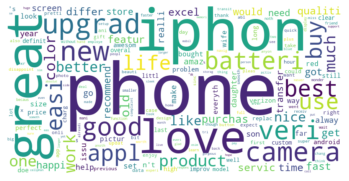

In [20]:
# Plot a new wordcloud with the stemmed words
wordcloud = WordCloud(width=800, height=400, background_color='white', contour_color='white')
wordcloud.generate_from_frequencies(frequencies=df_fdist.Frequency)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

The word cloud is now different but the words keep having the same frecuency. The difference lies in words like "iphone" that now is "iphon".

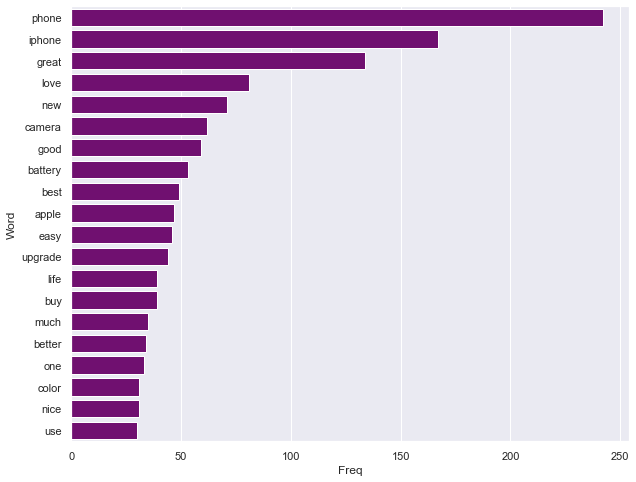

In [22]:
# PLOT top 20 most frequently occuring UNI-GRAMS
top_words = get_top_n_words(processedReviews['PreProcessedText'], n=20, nGrams=1)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
sns.set(rc={'figure.figsize':(10,8)})
g = sns.barplot(data=top_df, x="Freq", y="Word", color="purple")

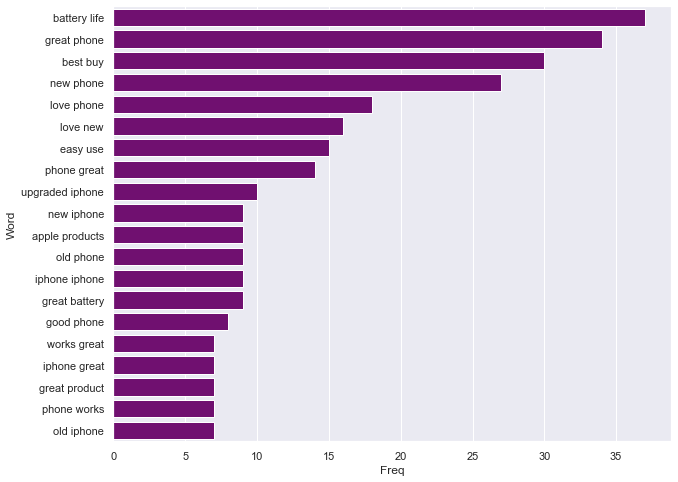

In [23]:
# PLOT top 20 most frequently occuring BI-GRAMS
top_words = get_top_n_words(processedReviews['PreProcessedText'], n=20, nGrams=2)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
sns.set(rc={'figure.figsize':(10,8)})
g = sns.barplot(data=top_df, x="Freq", y="Word", color="purple")

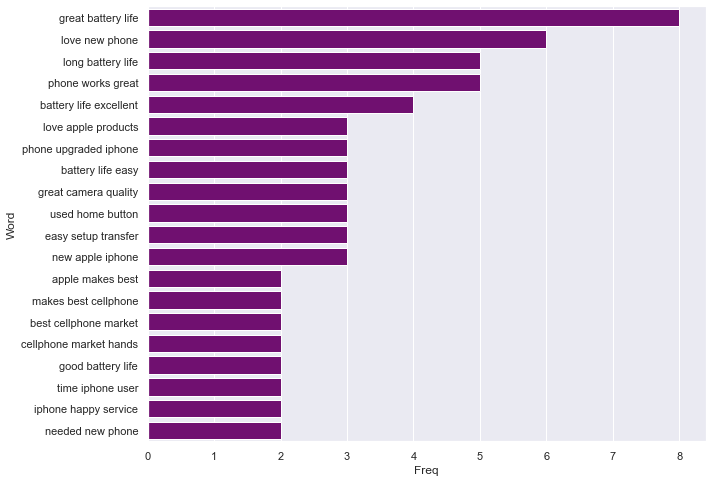

In [24]:
# PLOT top 20 most frequently occuring TRI-GRAMS
top_words = get_top_n_words(processedReviews['PreProcessedText'], n=20, nGrams=3)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
sns.set(rc={'figure.figsize':(10,8)})
g = sns.barplot(data=top_df, x="Freq", y="Word", color="purple")